# Sentiment Analysis on Amazon Reviews
**Author:** Meri Asatryan  
**Date:** April 17, 2025  

## Project Overview

In this project, we perform sentiment analysis on the [Amazon Review Polarity Dataset](https://www.kaggle.com/datasets/bittlingmayer/amazonreviews). The goal is to classify product reviews as either **positive** or **negative** based on their content.

We explore both **classical machine learning models** (Naive Bayes, Logistic Regression, and SVM) and a **transformer-based deep learning model** (BERT) to compare performance and demonstrate the benefits of modern NLP techniques.

---

### Key Components:
- **Data Cleaning and Preprocessing** using NLTK and regex
- **Exploratory Data Analysis** with word clouds and visualizations
- **Classical ML Models** with TF-IDF features
- **Fine-tuned BERT Model** using HuggingFace Transformers
- **Model Evaluation** with precision, recall, F1-score, and accuracy
- **Real-time Sentiment Prediction** using the trained model

---




### Setting Up the Environment

We begin by **installing** all the necessary Python packages and **importing** modules that we’ll use throughout the notebook. This includes libraries for:
- Text processing (`nltk`, `re`, `tqdm`)
- Visualization (`matplotlib`, `wordcloud`)
- Machine learning (`scikit-learn`)
- Deep learning (`transformers`, `datasets`)

In [ ]:
#Install all required libraries
!pip install -U gdown nltk tqdm wordcloud transformers datasets

#Imports for data handling and processing
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud

#Classical ML
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

#Transformers
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments, pipeline
)
from datasets import Dataset
import torch

#Download NLTK stopwords
nltk.download('stopwords')

#Setup device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)


### Downloading the Dataset

We use `gdown` to download the Amazon Review Polarity dataset from a shared Google Drive folder. This dataset contains 3.6 millions of reviews labeled as either positive or negative. It forms the foundation for training and evaluating our sentiment analysis models.


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1P_T7loBWVaDDl8hRu0W6F5bmwOisQPEv

Mounted at /content/drive


### Loading the Review Data

We load the dataset into Pandas DataFrames and assign meaningful column names (`rating`, `review_title`, `review_text`). This step helps us quickly inspect the structure of the data and prepares it for preprocessing.


In [ ]:
import pandas as pd

train_file_path = '/content/amazon_review_polarity_csv/train.csv'
test_file_path = '/content/amazon_review_polarity_csv/test.csv'


train_data = pd.read_csv(train_file_path, header=None)
train_data.columns = ['rating', 'review_title', 'review_text']
test_data = pd.read_csv(test_file_path)
test_data.columns = ['rating', 'review_title', 'review_text']


print(train_data.head())


   rating                                       review_title  \
0       2                     Stuning even for the non-gamer   
1       2              The best soundtrack ever to anything.   
2       2                                           Amazing!   
3       2                               Excellent Soundtrack   
4       2  Remember, Pull Your Jaw Off The Floor After He...   

                                         review_text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  


In [ ]:
print(train_data.columns)
print(test_data.columns)


Index(['rating', 'review_title', 'review_text'], dtype='object')
Index(['rating', 'review_title', 'review_text'], dtype='object')


### Cleaning and Normalizing Review Text

To make the data usable for machine learning, we clean the review text:
- Remove HTML tags, special characters, and numbers
- Convert all text to lowercase
- Remove common stopwords using NLTK

We also use `tqdm` to visually track progress, as this cleaning process is applied to hundreds of thousands of reviews.


In [ ]:
import re
import nltk
from tqdm import tqdm

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Add tqdm to show progress while applying the cleaning function
tqdm.pandas()

# Clean the review text in both train and test data with progress bar
train_data['cleaned_review'] = train_data['review_text'].progress_apply(clean_text)
test_data['cleaned_review'] = test_data['review_text'].progress_apply(clean_text)

# Display cleaned text
print(train_data[['review_text', 'cleaned_review', "rating"]].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 399999/399999 [00:43<00:00, 9092.69it/s]


                                         review_text  \
0  This sound track was beautiful! It paints the ...   
1  I'm reading a lot of reviews saying that this ...   
2  This soundtrack is my favorite music of all ti...   
3  I truly like this soundtrack and I enjoy video...   
4  If you've played the game, you know how divine...   

                                      cleaned_review  rating  
0  sound track beautiful paints senery mind well ...       2  
1  im reading lot reviews saying best game soundt...       2  
2  soundtrack favorite music time hands intense s...       2  
3  truly like soundtrack enjoy video game music p...       2  
4  youve played game know divine music every sing...       2  


### Inspecting Cleaned Reviews

We display examples of the original and cleaned review text side-by-side. This helps confirm that our preprocessing function is working as expected and producing usable input for modeling.


In [ ]:
# Filter rows where the rating is 1 (negative reviews)
negative_reviews = train_data[train_data['rating'] == 2]

# Display the relevant columns (review text, cleaned review, and rating)
print(negative_reviews[['review_text', 'cleaned_review', 'rating']].head())


                                         review_text  \
0  This sound track was beautiful! It paints the ...   
1  I'm reading a lot of reviews saying that this ...   
2  This soundtrack is my favorite music of all ti...   
3  I truly like this soundtrack and I enjoy video...   
4  If you've played the game, you know how divine...   

                                      cleaned_review  rating  
0  sound track beautiful paints senery mind well ...       2  
1  im reading lot reviews saying best game soundt...       2  
2  soundtrack favorite music time hands intense s...       2  
3  truly like soundtrack enjoy video game music p...       2  
4  youve played game know divine music every sing...       2  


Visualizing Sentiment Distribution (Training Set)

To understand how balanced our dataset is, we first count how many reviews are labeled as positive and how many as negative.

We then use a bar chart to plot these counts:
- **Red bar** for negative sentiment (label 1)
- **Green bar** for positive sentiment (label 2)

This visualization is crucial because class imbalance can significantly impact model performance. Ideally, we want both classes to be relatively balanced, or we need to account for the imbalance during training.


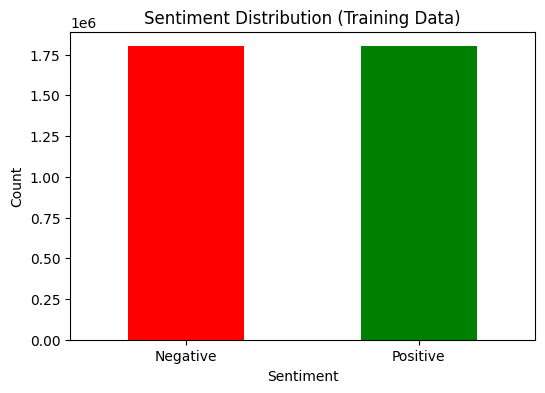

In [ ]:
import matplotlib.pyplot as plt

# Count the number of positive and negative reviews
sentiment_counts = train_data['rating'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution (Training Data)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()


The bar chart shows the number of **positive** and **negative** reviews in the training dataset.

**Observation:**
- The two bars (red for negative, green for positive) are nearly **equal in height**, meaning the dataset is **perfectly balanced**.
- This is ideal for a classification task because the model gets an equal opportunity to learn from both classes.
- There's no need for resampling techniques like oversampling or undersampling.

**Why it's important:**
A balanced dataset ensures that the model:
- Doesn’t become biased toward the majority class
- Achieves **more reliable precision and recall** for both positive and negative predictions

This strong class balance gives us a good foundation for fair model training and evaluation.

### Distribution of Review Lengths

In this step, we calculate the number of words in each cleaned review. This helps us:
- Get a feel for how verbose users are in their reviews
- Decide how long input sequences should be when fed into models like BERT
- Identify and filter out extremely short or long reviews if necessary

We use a histogram to visualize the distribution. Most reviews tend to be between 20–100 words, which guides padding and truncation settings for tokenization later.


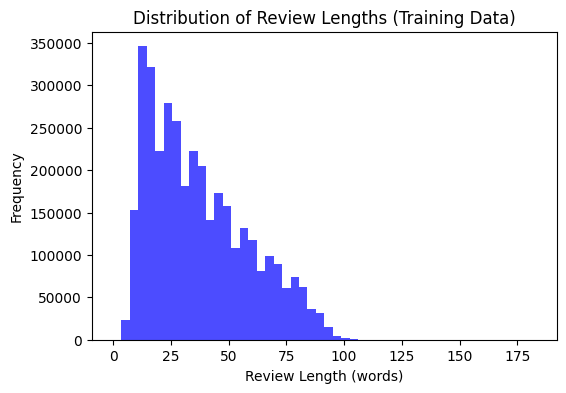

In [ ]:
# Calculate the length of each review
train_data['review_length'] = train_data['cleaned_review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(6, 4))
train_data['review_length'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths (Training Data)')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()


This histogram visualizes how long the reviews are in terms of **number of words** after text cleaning.

---

**Key Observations:**
- Most reviews fall within the **10 to 60 word** range.
- There is a **sharp peak around 15–20 words**, showing that many users write brief reviews.
- The distribution is **right-skewed** (long tail to the right), meaning a smaller number of reviews are significantly longer, going up to **150+ words**.
- Very few reviews are longer than 100 words, which helps us decide a good **maximum sequence length** (e.g., 128 tokens) for BERT.

---

**Why this matters:**
- Helps in deciding the **input size** for models like BERT (to avoid unnecessary padding or truncation).
- Provides a better understanding of **user writing behavior** — most reviews are short, informal, and concise.
- We might choose to filter out extremely short reviews (e.g., less than 5 words) if they don’t provide useful sentiment cues.

### Word Cloud of Frequent Bigrams
Before generating the word clouds, we enhance the cleaned reviews by removing both general and domain-specific stopwords (like “book”, “movie”, “really”), and convert the text into bigrams—two-word combinations that better capture context.

We sample 10,000 reviews from each sentiment class, transform them into bigrams, and combine them into strings. Then, we generate separate word clouds for positive and negative reviews, which help us visualize the most common meaningful phrases used in each group.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1800000/1800000 [00:01<00:00, 1424720.39it/s]


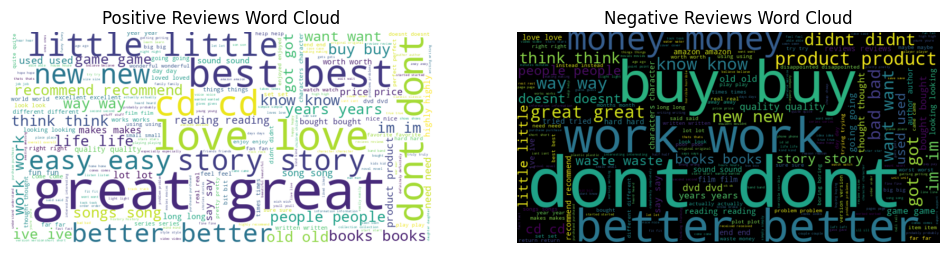

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import nltk

# Download NLTK stopwords
nltk.download('stopwords')

# Add more domain-specific stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({"book", "one", "movie", "good", "really", "time", "like", "even", "use", "make", "thing", "read", "music", "album"})

# Create bigrams from the cleaned reviews
def generate_bigrams(text):
    words = text.split()
    bigrams = [' '.join([words[i], words[i+1]]) for i in range(len(words)-1)]
    return ' '.join(bigrams)

positive_reviews = train_data[train_data['rating'] == 2]['cleaned_review'].progress_apply(lambda x: x)
negative_reviews = train_data[train_data['rating'] == 1]['cleaned_review'].progress_apply(lambda x: x)

positive_reviews_sample = positive_reviews.sample(10000)
negative_reviews_sample = negative_reviews.sample(10000)
# Apply bigram transformation
positive_reviews_bigrams = positive_reviews_sample.apply(generate_bigrams)
negative_reviews_bigrams = negative_reviews_sample.apply(generate_bigrams)

# Combine the positive and negative reviews into one string
positive_text = ' '.join(positive_reviews_bigrams)
negative_text = ' '.join(negative_reviews_bigrams)

# Generate word clouds with bigrams and refined stopwords
positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords, max_words=200).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='black', stopwords=custom_stopwords, max_words=200).generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


### Fine-Tuning BERT for Sentiment Classification
We use the HuggingFace transformers library to fine-tune a pre-trained BERT model (bert-base-uncased) for binary sentiment classification.

Steps include:

Installing required libraries and checking GPU availability

Converting review ratings into binary labels (0 = negative, 1 = positive)

Sampling smaller subsets of the dataset for faster training

Tokenizing reviews with padding and truncation

Formatting the data into PyTorch-compatible tensors

Initializing a BERT model for sequence classification

Defining training parameters using TrainingArguments

Training the model using the Trainer API

In [ ]:
!pip install transformers datasets

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# ✅ GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# ✅ Convert ratings to binary labels (1 = positive, 0 = negative)
train_data['labels'] = train_data['rating'].apply(lambda x: 1 if x == 2 else 0)
test_data['labels'] = test_data['rating'].apply(lambda x: 1 if x == 2 else 0)

# ✅ Reduce dataset size for quicker testing (optional for Colab runtime limits)
train_sample = train_data.sample(10000, random_state=42).reset_index(drop=True)
test_sample = test_data.sample(2000, random_state=42).reset_index(drop=True)

# ✅ Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_sample[['cleaned_review', 'labels']])
test_dataset = Dataset.from_pandas(test_sample[['cleaned_review', 'labels']])

# ✅ Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(example):
    return tokenizer(example['cleaned_review'], padding='max_length', truncation=True)

# ✅ Tokenize
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# ✅ Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# ✅ Load BERT model for binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# ✅ Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

# ✅ Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# ✅ Train using GPU
trainer.train()

# ✅ Evaluate model performance
eval_results = trainer.evaluate()
print("📊 Evaluation results:", eval_results)


After training, we evaluate BERT's performance on the test dataset by generating a detailed classification report.

We:

* Use the trained Trainer to predict labels on the test set

* Extract true and predicted labels

* Compute precision, recall, F1-score, and support using classification_report

This helps us understand how well the model distinguishes between positive and negative reviews, and whether it performs consistently across both classes.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      1005
    Positive       0.86      0.87      0.87       995

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



The BERT model achieved 87% accuracy with balanced precision, recall, and F1-scores (0.87) for both negative and positive reviews.
This shows strong, consistent performance across classes with no sign of bias.

In [ ]:
model.save_pretrained('/content/drive/MyDrive/bert_sentiment_model')
tokenizer.save_pretrained('/content/drive/MyDrive/bert_sentiment_model')


('/content/drive/MyDrive/bert_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_sentiment_model/vocab.txt',
 '/content/drive/MyDrive/bert_sentiment_model/added_tokens.json')

We use the trained model in a HuggingFace pipeline to make predictions on new review text.

This shows the model’s ability to generalize and classify unseen user feedback correctly and confidently.



In [ ]:
feedback = "The app is easy to use and the interface is very clean. Great experience!"


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch

# === Load your model & tokenizer ===
model_path = "/content/drive/MyDrive/bert_sentiment_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Create pipeline ===
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# === Example feedback ===
example_feedback = "I love how fast the checkout process is. Super smooth and easy to use!"

# === Run prediction ===
result = sentiment_pipeline(example_feedback)
label = result[0]['label']
score = result[0]['score']

# === Interpret label ===
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive"
}
print(f"📝 Feedback: {example_feedback}")
print(f"✅ Predicted Sentiment: {label_map[label]} (Confidence: {score:.4f})")


Device set to use cuda:0


📝 Feedback: I love how fast the checkout process is. Super smooth and easy to use!
✅ Predicted Sentiment: Positive (Confidence: 0.9948)


We pass in a clearly negative review to confirm that the model accurately classifies it as negative, with high confidence.

In [ ]:
example_feedback = "This product is terrible. It broke after two days and the customer support was unhelpful."


In [ ]:
result = sentiment_pipeline(example_feedback)
label = result[0]['label']
score = result[0]['score']

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive"
}

print(f"📝 Feedback: {example_feedback}")
print(f"✅ Predicted Sentiment: {label_map[label]} (Confidence: {score:.4f})")


📝 Feedback: This product is terrible. It broke after two days and the customer support was unhelpful.
✅ Predicted Sentiment: Negative (Confidence: 0.9945)


### Classical ML Models with TF-IDF
We train baseline models (Naive Bayes, Logistic Regression, and SVM) using TF-IDF vectorized features.

This allows for comparison between classical approaches and BERT, highlighting the performance gap.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Sample smaller dataset for classical ML
sample_train = train_data.sample(10000, random_state=42)
sample_test = test_data.sample(2000, random_state=42)

# Extract features and labels
X_train = sample_train['cleaned_review']
y_train = sample_train['rating']
X_test = sample_test['cleaned_review']
y_test = sample_test['rating']

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


### Naive Bayes Model
We fit a Multinomial Naive Bayes model and generate a classification report to evaluate its performance.



In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("🔹 Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=["Negative", "Positive"]))


🔹 Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      1005
    Positive       0.82      0.81      0.82       995

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



### Logistic Regression (with Grid Search)
We use GridSearchCV to tune hyperparameters and train a Logistic Regression model.
The report shows improvements over Naive Bayes, especially in accuracy.

In [ ]:
logreg = LogisticRegression(max_iter=1000)
params_logreg = {'C': [0.01, 0.1, 1, 10]}
grid_logreg = GridSearchCV(logreg, params_logreg, cv=3, scoring='accuracy')
grid_logreg.fit(X_train_tfidf, y_train)
y_pred_logreg = grid_logreg.predict(X_test_tfidf)

print("🔹 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=["Negative", "Positive"]))


🔹 Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.84      0.83      1005
    Positive       0.83      0.83      0.83       995

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



### Support Vector Machine (SVM)
We train a linear-kernel SVM classifier and evaluate it using the same test data.
Its performance is close to Logistic Regression, with balanced precision and recall.

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("🔹 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Negative", "Positive"]))


🔹 SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.82      1005
    Positive       0.82      0.82      0.82       995

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [ ]:
print("✅ Accuracy Summary:")
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Logistic Regression Accuracy (best params): {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


✅ Accuracy Summary:
Naive Bayes Accuracy: 0.8175
Logistic Regression Accuracy (best params): 0.8320
SVM Accuracy: 0.8235


Among the baseline models, Logistic Regression achieved the highest performance with an accuracy of 83.2%. However, the BERT-based model significantly outperformed all classical methods, reaching an accuracy of 87% with balanced precision, recall, and F1-score. This improvement demonstrates the value of using transformer-based architectures for sentiment analysis tasks, especially when dealing with nuanced textual data.